# Summary

This exercise pretends to implement a multilayer perceptron neural network from scratch. Justifying some choices giving the apropiate explanations. The details of the process of feed forward, back forward, loss function and how neural networks works will not be covered in this document as the purpose of this is to serve as a first hands on experience to someone that just finished a deeplearning course or specialization. So some background in this fiel is required.

Using the stanford dogs breed database and taking the multilayer perceptron architecture from deeplearning.ai specialization, I will try to:

- implement a multiclass classification through Softmax output activation    layer.

- Implement mini-batches to improve the algorithm and try to avoid overfitting.

- Implement momentum to accelerate the cost minimization process.

- Fine tunning the hyperparameters and try different layers/neurons setups.

## Neural networks and Softmax activation function

Binary multilayer perceptron neural networks are networks used to classify two classes that usually follows the next architecture:

<img src="explanation_images/NlayerNN.png" style="width:700px;height:500px;">
<caption><center> <br> **Figure 1** </br> L-layer neural network. <br> ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption> <br>

these neural networks have a number of hidden layers where weights and previous activations are computed linearly and then activated by a function of your choice. For this hidden layers ReLU  is usually the choice (better for computation and avoid vanishing) but sigmoid, tanh, leaky ReLU are other options depending on the application.

As this is a Binary neural network the output layers is activated by a Sigmoid function making the predicted value to be in the range [0:1], where the value 0.5 is a treshold for a binary "true" or false. In this example, is a cat, or not.

To tackle the multicassification problem, Softmax function turns out to be necessary. As we will be classifiying more than two items, we need an activation function capable of predict more than two outcomes, exactly as softmax function does.

<img src="explanation_images/Softmax.jpg" style="width:900px;height:400px;">
<caption><center>  L-layer neural network. <br> ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SOFTMAX***</center></caption> <br>

As we can see, for the output layer instead of one neuron we have as many neurons as classes we intend to identify. Each neuron will contain the probability of the corresponding class.

To achieve this, Softmax can assign a probability for the logits associated to a class, as we can see in the following figure:


<img src="explanation_images/softmax_logits.png" style="width:700px;height:300px;">
<caption><center> L-layer neural network. <br> ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SOFTMAX***</center></caption> <br>

Nonetheless, to work with Softmax function we must encode the labels as per the following figure:

<img src="explanation_images/hands.png" style="width:700px;height:300px;">
<caption><center> </center></caption> <br>

this one hot encoding maps a label to a one vector of zeros with length equal to the maximum number of classes where the class for the item will be a one. This is necessary to properly calculate the cross-entropy loss.

# Data preparation

credit to: Terrance Whitehurst

https://www.kaggle.com/twhitehurst3/stanford-dogs-keras-vgg16

This part of the code aims to prepare the data to train the neural network. It generates the folders that will contain the different images cropped to the same size, labelled and then encoded through a onehotencoder to prepare the labels accordingly to the requirements of the softmax output layer.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
global_path = ''

In [3]:
import os
import sys
sys.path.insert(0, os.path.join(global_path))

from dnn_utils_v2 import relu, relu_backward, softmax, softmax_backward

import math

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET


import numpy as np
import scipy

from skimage.io import imread
from skimage.transform import resize
from PIL import Image

from sklearn.model_selection import train_test_split

Create folders that will contain the cropped images for the selected breeds.


In [4]:
breed_list = os.listdir(os.path.join(global_path, 'Images'))
num_classes = len(breed_list)
print("{} breeds".format(num_classes))
print(breed_list)

4 breeds
['n02085936-Maltese_dog', 'n02099601-golden_retriever', 'n02106662-German_shepherd', 'n02109525-Saint_Bernard']


In [ ]:
%%time

# copy from https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation


os.mkdir(global_path + 'data')
for breed in breed_list:
    os.mkdir(global_path + 'data/' + breed)

print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))



Created 4 folders to store cropped images of the different breeds.
CPU times: user 1.07 ms, sys: 2.05 ms, total: 3.12 ms
Wall time: 1.87 ms


In [5]:
#paths

images_path = os.path.join(global_path, 'images')
data_path = os.path.join(global_path, 'data')
annotation_path = os.path.join(global_path, 'Annotation')

In [6]:
num_px = 80

In [44]:
for breed in breed_list: 
    for file in os.listdir(os.path.join(annotation_path, f'{breed}')):
            img = Image.open(os.path.join(images_path, f'{breed}', f'{file}.jpg'))
            tree = ET.parse(os.path.join(annotation_path, f'{breed}', f'{file}'))
            xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
            xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
            ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
            ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
            img = img.crop((xmin, ymin, xmax, ymax))
            img = img.convert('RGB')
            img = img.resize((num_px, num_px))
            img.save(os.path.join(data_path, breed, file + '.jpg'))

FileNotFoundError: ignored

Check and print information about the number of breeds and images we will be working with.

In [7]:
n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir(os.path.join(data_path, f'{breed}')))
print(n_total_images)

724


Showing some images for the classified breeds along with its label

In [8]:
label_maps = {}
for w, j in enumerate(breed_list):
    label_maps.update({j: w})

In [9]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = global_path + 'data/{}'.format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + '/' + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

n02085936-Maltese_dog


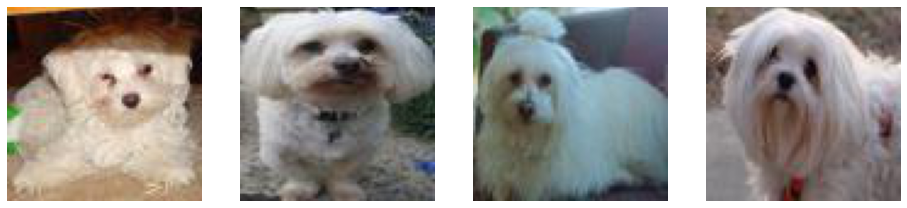

In [10]:
i = 0
print(breed_list[i])
show_dir_images(breed_list[i], 4)

Generate the Matrix with the input data it will consist on a Matrix of:

- "X" rows: where "X" is the image pixels unrolled by its height and width and number of channels (RGB)
- "Y" columns: where "Y" is the number of images

In [11]:
matrix = []
labels = []
targets = []
for i, breed in enumerate(os.listdir(global_path + 'data/')): 
        for file in os.listdir(global_path + 'Annotation/{}'.format(breed)):
                img = imread(os.path.join(data_path, f'{breed}', f'{file}.jpg'))
                reshaped_img = np.reshape(img, [num_px*num_px*3, 1])
                matrix.append(reshaped_img)
                labels.append(breed)
                targets.append(label_maps[breed])
                

In [13]:
X_mat = np.reshape(matrix, [len(matrix), num_px*num_px*3])
labels = np.reshape(labels, [len(matrix), 1])
targets = np.reshape(targets, [len(matrix), 1])
print(X_mat.shape)
print(labels.shape)
print(targets.shape)

(724, 19200)
(724, 1)
(724, 1)


n02106662-German_shepherd
2


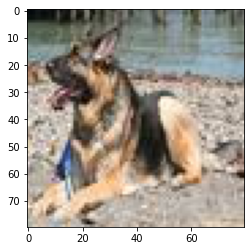

In [14]:
i = 600
plt.imshow(np.reshape(X_mat[i, :], [num_px, num_px, 3]))
print(labels[i, 0])
print(targets[i, 0])

Preparing the data to give a good distribution/representation of the population. Shuffling and splitting the total amount of images into a train and test sets.

In [15]:
x_train, x_valid, y_train, y_valid = train_test_split(X_mat, targets, test_size=0.20, shuffle= True)
x_train = x_train.T
y_train = y_train.T
x_valid = x_valid.T
y_valid = y_valid.T
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(19200, 579)
(1, 579)
(19200, 145)
(1, 145)


In [16]:
def show_image(i, X, Y):
  plt.imshow(np.reshape(X[:, i], [num_px, num_px, 3]))
  print(Y[0, i])

3


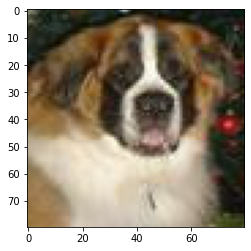

In [17]:
show_image(300, x_train, y_train)

As my aim is to implement a Softmax function to multiclassification, the current labelling should be encoded through a one hot encoding function to prepare the labels accordingly.

In [18]:
def one_hot_encoding(X, Y):
  one_hot_encoding = np.zeros((len(breed_list), X.shape[1]))
  for i in range(0, len(breed_list)):
    one_hot_encoding[i] = Y ==i
  print(one_hot_encoding)
  print(one_hot_encoding.shape)
  Y = one_hot_encoding

  return Y



In [19]:
y_train = one_hot_encoding(x_train, y_train)

[[0. 0. 1. ... 1. 1. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(4, 579)


In [20]:
y_valid = one_hot_encoding(x_valid, y_valid)

[[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1.
  1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0.
  0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  1.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
  1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
  0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 0. 0. 1. 0. 0. 

[0. 1. 0. 0.]


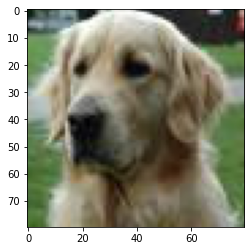

In [21]:
i = 0
plt.imshow(np.reshape(x_train[:, i], [num_px, num_px, 3]))
print(y_train[:, i])

[0. 0. 1. 0.]


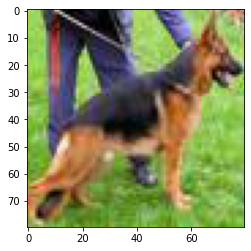

In [22]:
i = 0
plt.imshow(np.reshape(x_valid[:, i], [num_px, num_px, 3]))
print(y_valid[:, i])

In [23]:
#NORMALIZATION
x_train = x_train/255
x_valid = x_valid/255


# NEURAL NETWORK

based on the neural network from scratch on deeplearning specialization from deeplearning.ai

- momentum implemented
- minibatch implemented

In [24]:
### Multilayer perceptron (layers & neurons) ###
layers_dims = [num_px*num_px*3, 9500, 1000, len(breed_list)] #  4-layer model
len(layers_dims)

4

In [25]:
def initialize_parameters_deep(layer_dims):

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    

        
    return parameters

In [26]:
# Parameters initialization

parameters = initialize_parameters_deep(layers_dims)

for l in range(1, len(layers_dims)):
  print(parameters["W" + str(l)].shape)

(9500, 19200)
(1000, 9500)
(4, 1000)


In [27]:
#linear_forward

def linear_forward(A, W, b):

    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [28]:
#linear_activation_forward

def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    A, activation_cache = activation(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    
    return A, cache
                    
    


In [29]:
#L_model_forward

def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                 
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], relu)
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], softmax)
    caches.append(cache)
    
    assert(AL.shape == (len(breed_list),X.shape[1]))
            
    return AL, caches

In [30]:
AL, caches = L_model_forward(x_train, parameters)
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))
AL.shape

AL = [[0.27335776 0.25635959 0.26091987 ... 0.26470112 0.24055734 0.24699168]
 [0.24794103 0.26540116 0.24189494 ... 0.26187051 0.26173488 0.26721704]
 [0.25199776 0.25268107 0.25906058 ... 0.2513641  0.26908893 0.25586235]
 [0.22670346 0.22555818 0.23812462 ... 0.22206427 0.22861885 0.22992894]]
Length of caches list = 3


(4, 579)

In [31]:
# compute_cost

def compute_cost(AL, Y):

    m = Y.shape[1]

    cost = -np.sum(Y * np.log(AL + 1e-6))
    
    cost = np.squeeze(cost)    
    
    
    return cost



In [32]:
compute_cost(AL, y_train)

print("cost = " + str(compute_cost(AL, y_train)/x_train.shape(1)))


cost = 806.8062134222978


In [33]:
# linear_backward

def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*(np.sum(dZ, axis = 1, keepdims = True))
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [34]:
# linear_activation_backward

def linear_activation_backward(dA, cache, Y, AL, activation):

    linear_cache, activation_cache = cache

    if activation == "softmax":
        dZ = softmax_backward(AL, Y, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [35]:
# L_model_backward

def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    
    dAL =  -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (Softmax -> LINEAR) gradients. 
    current_cache = caches[L - 1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, Y, AL, activation = 'softmax')
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache,Y, AL, activation = 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp


    return grads

In [36]:
# initialize_velocity

def initialize_velocity(parameters):

    L = len(parameters)  // 2
    velocity = {}
    
    for l in range(L):
        velocity["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        velocity["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        
    return velocity

In [37]:
# update_parameters

def update_parameters(parameters, grads, velocity, learning_rate):

    L = len(parameters) // 2
    beta= 0.9

    for l in range(L):
        velocity["dW" + str(l+1)] = beta*velocity['dW' + str(l+1)] + (1-beta)*grads['dW' + str(l+1)]
        velocity["db" + str(l+1)] = beta*velocity['db' + str(l+1)] + (1-beta)*grads['db' + str(l+1)]

        parameters["W" + str(l+1)] = parameters['W' + str(l+1)] - learning_rate*velocity['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters['b' + str(l+1)] - learning_rate*velocity['db' + str(l+1)]

    return parameters, velocity

In [38]:
# random_mini_batches

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    
    np.random.seed(seed)            
    m = X.shape[1]                  
    mini_batches = []
        
    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((len(breed_list),m))

    # Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):

        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[:, k*mini_batch_size : m-mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : m-mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [39]:
def mypredict(X, y, parameters):
    
    # Forward propagation
    probabilities, caches = L_model_forward(X, parameters)
    predict = np.argmax(probabilities, axis=0)
    
    
    return probabilities, predict

In [40]:
def accuracy_calc(X, Y, parameters):
    count = 0
    for i in range(0, Y.shape[1]):
      probabilities, a = mypredict(np.reshape(X[:, i], [num_px*num_px*3, 1]), Y, parameters)
      if a == np.argmax(Y[:, i]):
        count += 1
        accuracy = count/Y.shape[1]
        
    return accuracy 

In [41]:
# L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.01 , mini_batch_size = 32, num_iterations = 3000, print_cost=False):#lr was 0.009


    costs = []                         
    seed = 10 
    m = X.shape[1] 
    # Parameters initialization
    parameters = initialize_parameters_deep(layers_dims)
    velocity = initialize_velocity(parameters)
    
    # gradient descent
    for i in range(0, num_iterations):

        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:
            
          (minibatch_X, minibatch_Y) = minibatch
          
          # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SOFTMAX.
          AL, caches = L_model_forward(minibatch_X, parameters)

          
          # Compute cost.
          cost_total += compute_cost(AL, minibatch_Y)

      
          # Backward propagation.
          grads = L_model_backward(AL, minibatch_Y, caches)

          # Update parameters.
          parameters, velocity = update_parameters(parameters, grads, velocity, learning_rate)
          
        cost_avg = cost_total/m
        costs.append(cost_avg)
        
        
        # Print the cost every 2 training example and accuracies every 10
        if i % 2 == 0:
            print ("Cost after iteration %i: %f" %(i, cost_avg))
        

        if i % 10 == 0:
          accuracy = accuracy_calc(x_train, y_train, parameters)
          print("accuracy in training set is" + " " + str(accuracy))
          
          accuracy = accuracy_calc(x_valid, y_valid, parameters)
          print("accuracy in test set is" + " " + str(accuracy))
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 1.331479
accuracy in training set is 0.4939550949913644
accuracy in test set is 0.4482758620689655
Cost after iteration 2: 1.077156
Cost after iteration 4: 0.938550
Cost after iteration 6: 0.820718
Cost after iteration 8: 0.733125
Cost after iteration 10: 0.674227
accuracy in training set is 0.7012089810017271
accuracy in test set is 0.6758620689655173
Cost after iteration 12: 0.618119
Cost after iteration 14: 0.594147
Cost after iteration 16: 0.516755
Cost after iteration 18: 0.440129
Cost after iteration 20: 0.463234
accuracy in training set is 0.8825561312607945
accuracy in test set is 0.7103448275862069
Cost after iteration 22: 0.377750
Cost after iteration 24: 0.322963
Cost after iteration 26: 0.256771
Cost after iteration 28: 0.224812
Cost after iteration 30: 0.213905
accuracy in training set is 0.9101899827288429
accuracy in test set is 0.6758620689655173
Cost after iteration 32: 0.181283
Cost after iteration 34: 0.132010
Cost after iteration 36: 0.111762

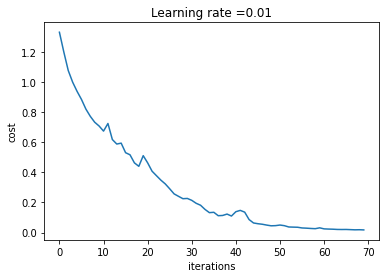

In [42]:
parameters = L_layer_model(x_train, y_train, layers_dims, num_iterations = 70, print_cost = True)

In [43]:
accuracy = accuracy_calc(x_train, y_train, parameters)

In [44]:
accuracy

1.0

In [45]:
accuracy = accuracy_calc(x_valid, y_valid, parameters)

In [46]:
accuracy

0.7034482758620689

In [57]:
def show_results(X, Y, range_start, range_end):

  for i in range (range_start, range_end):   
      probas, a = mypredict(np.reshape(X[:, i], [num_px*num_px*3, 1]), Y, parameters)
      plt.imshow(np.reshape(X[:, i], [num_px, num_px, 3]))
      print(Y[:, i])
      print(breed_list[int(a)])
      plt.show()

[0. 0. 1. 0.]
n02106662-German_shepherd


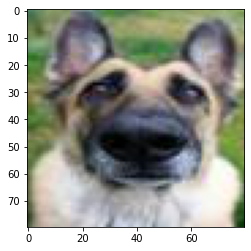

[0. 0. 0. 1.]
n02109525-Saint_Bernard


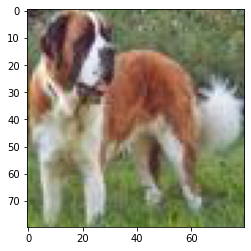

[0. 0. 1. 0.]
n02106662-German_shepherd


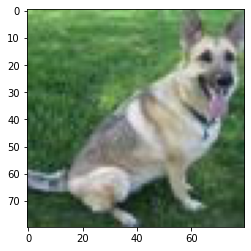

[0. 0. 0. 1.]
n02109525-Saint_Bernard


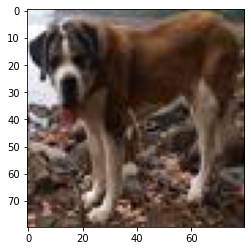

[0. 1. 0. 0.]
n02099601-golden_retriever


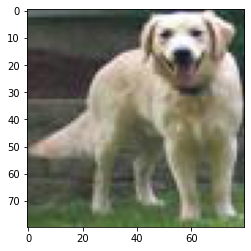

[0. 1. 0. 0.]
n02099601-golden_retriever


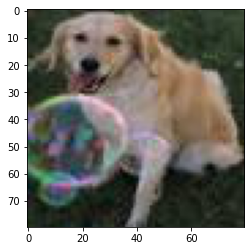

[0. 0. 0. 1.]
n02109525-Saint_Bernard


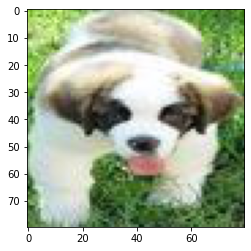

[1. 0. 0. 0.]
n02085936-Maltese_dog


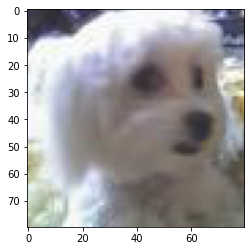

[0. 0. 0. 1.]
n02109525-Saint_Bernard


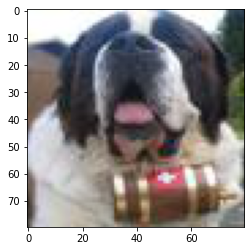

[0. 0. 1. 0.]
n02106662-German_shepherd


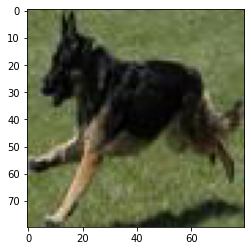

[0. 0. 1. 0.]
n02106662-German_shepherd


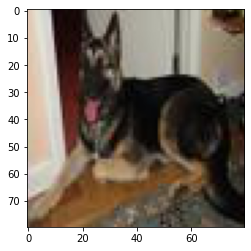

[0. 1. 0. 0.]
n02099601-golden_retriever


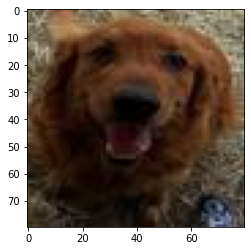

[0. 1. 0. 0.]
n02099601-golden_retriever


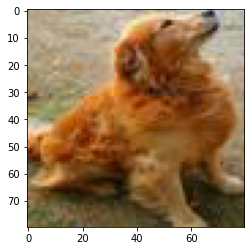

[0. 0. 1. 0.]
n02106662-German_shepherd


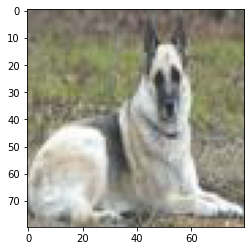

[1. 0. 0. 0.]
n02085936-Maltese_dog


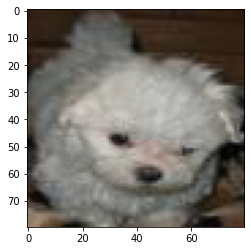

[1. 0. 0. 0.]
n02085936-Maltese_dog


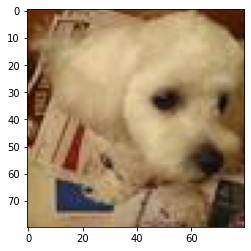

[1. 0. 0. 0.]
n02085936-Maltese_dog


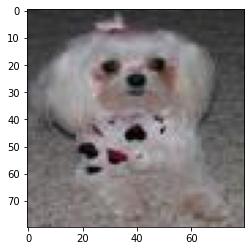

[1. 0. 0. 0.]
n02085936-Maltese_dog


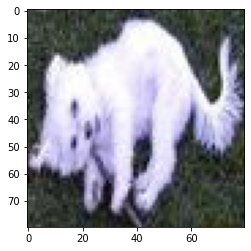

[0. 0. 0. 1.]
n02109525-Saint_Bernard


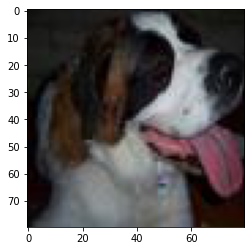

[0. 0. 1. 0.]
n02106662-German_shepherd


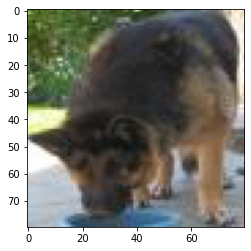

In [58]:
show_results(x_train, y_train, 180, 200)

[0. 0. 0. 1.]
n02109525-Saint_Bernard


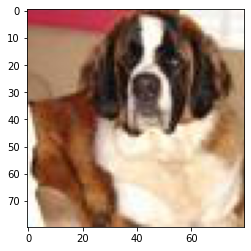

[0. 0. 1. 0.]
n02106662-German_shepherd


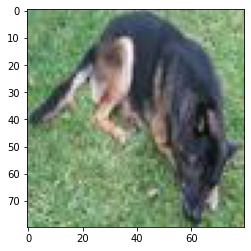

[1. 0. 0. 0.]
n02085936-Maltese_dog


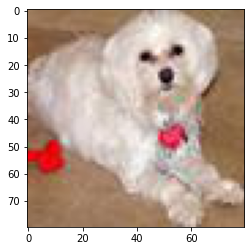

[0. 1. 0. 0.]
n02099601-golden_retriever


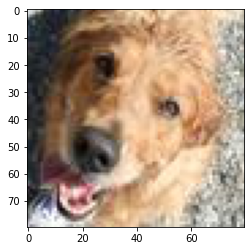

[1. 0. 0. 0.]
n02085936-Maltese_dog


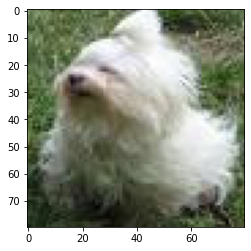

[1. 0. 0. 0.]
n02109525-Saint_Bernard


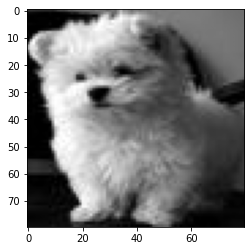

[1. 0. 0. 0.]
n02085936-Maltese_dog


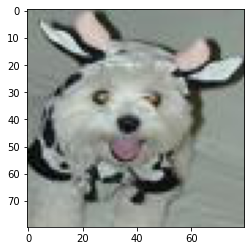

[0. 1. 0. 0.]
n02085936-Maltese_dog


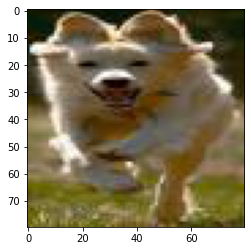

[1. 0. 0. 0.]
n02085936-Maltese_dog


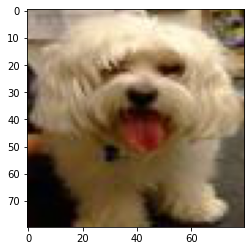

[0. 0. 0. 1.]
n02109525-Saint_Bernard


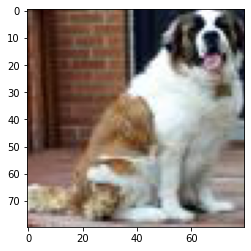

In [59]:
show_results(x_valid, y_valid, 100, 110)